In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import dill as pickle
import os
import random
import datetime 
import sys 
import seaborn as sns
from einops import rearrange
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.flasso.Replicate import Replicate
from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_cosines import get_cosines
from codes.plotting.supportrecovery import plot_watch3,plot_reg_path_ax_lambdasearch_customcolors_norm
from itertools import combinations

def get_names(subset):
    
    names = np.zeros(len(subset), dtype = object)
    for s in range(len(subset)):
        names[s] = r"$g_{{{}}}$".format(subset[s])
    return(names)

def get_color_subset(color_superset, superset, subset):
    
    colors_subset = np.zeros((len(subset),4 ))
    print(subset.shape,colors_subset.shape)
    for s in range(len(subset)):
        colors_subset[s] = color_superset[np.where(superset == subset[s])[0]] 
    return(colors_subset)
def get_detected_values(subset, supports):
    
    detected_values = np.zeros((subset.shape[0],subset.shape[0]))
    nreps = len(list(supports.keys()))
    for r in range(nreps):
        i1 = np.where(subset == int(supports[r][0]))[0]
        i2 = np.where(subset == int(supports[r][1]))[0]
        detected_values[i1,i2] += 1
        detected_values[i2,i1] += 1
    
    detected_values = np.asarray(np.where(detected_values > 0))
    return(detected_values)

def get_support_indices(sup_set, sup_sel):
    
    toplot = np.zeros((sup_set.shape[0],sup_set.shape[0]))
    for r in range(nreps):
        i1 = np.where(sup_set == sup_sel[r][0])[0]
        i2 = np.where(sup_set == sup_sel[r][1])[0]
        toplot[i1,i2] += 1
        toplot[i2,i1] += 1   
    return(toplot)

def get_cmap(subset):
    
    cmap = plt.get_cmap('rainbow',len(subset))
    colors_subset = np.zeros((len(subset),4))
    for s in range(len(subset)):
        colors_subset[s] = cmap(s)   
        
    return(colors_subset)

In [2]:

#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0219_fullreplicates_small_abscos.pkl' ,
         'rb') as loader:
     replicates0 = pickle.load(loader)

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0223_fullreplicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


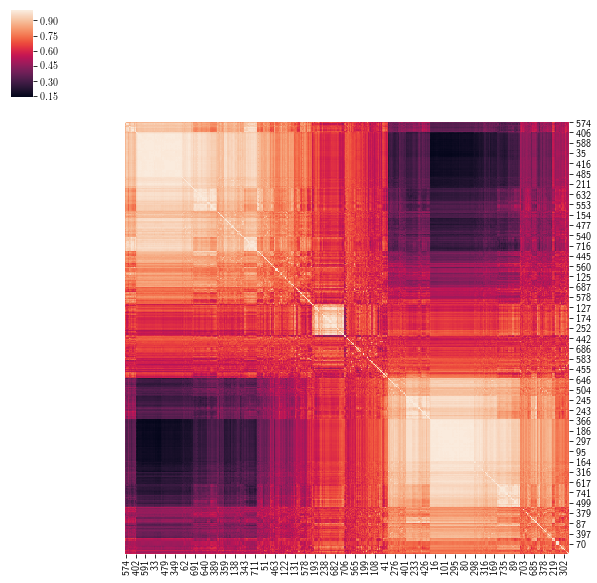

In [3]:
%matplotlib inline
r = 0
rep = replicates0[r]
clustermap = sns.clustermap(rep.cos)
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)

In [4]:
from codes.otherfunctions.utils import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max


nreps = 25
nsel = 100
min_mins = np.zeros(nreps, dtype = np.float64)
mus = np.zeros(nreps, dtype = np.float64)
kappas = np.zeros(nreps, dtype = np.float64)
gamma_maxs = np.zeros(nreps, dtype = np.float64)
n = nsel
for r in range(nreps):
    print(r)
    inds = np.asarray([0,8])#sel_tol[r]
    dg_M = replicates[r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(replicates[r].dg_M[:,:,inds[0]:(inds[0]+1)]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ) )

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [5]:
columns = np.asarray([r'$\bar \mu$', r'$\sigma_\mu$',
                     r'$\bar {\kappa_S}$', r'$\sigma_{\kappa_S}$',
                     r'$\bar {\gamma_{\text{max}}}$', r'$\sigma_{\gamma_{\text{max}}}$',
                     r'$\bar {\min_{i = 1}^{n} \min_{j \in S } ||x_{ij}|| }$', r'$\sigma_\mu$'])

In [6]:
import pandas as pd

In [7]:
df_mal_full = pd.DataFrame(np.asarray([np.mean(mus), np.sqrt(np.var(mus)), 
                    np.mean(kappas), np.sqrt(np.var(kappas)),
                    np.mean(gamma_maxs),np.sqrt(np.var(gamma_maxs)),
                    np.mean(min_mins),np.sqrt(np.var(min_mins))]).transpose(), index = columns).transpose()

In [44]:
df_mal_full.to_csv('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/malfullparam.csv')


In [8]:
#reorder lambdas and coefficients
nreps = 25
for r in range(nreps):
    cs = rearrange(np.asarray(list(replicates[r].results[1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(replicates[r].results[1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

In [9]:
#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    lambdas = np.asarray(list(replicates[r].results[1].keys()))
    lambdas.sort()
    sel_l[r] = np.where(lambdas ==  replicates[r].results[0])[0][0]

sel = {}
min_sel = {}
for r in range(nreps):
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    min_sel[r] =  np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[1] !=0.)[0]

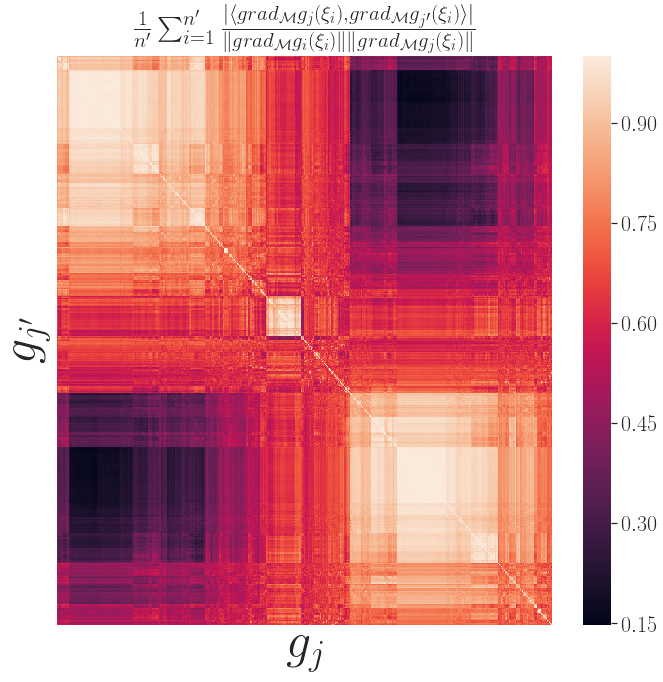

In [6]:
sns.set(font_scale=2)
f, axarr = plt.subplots(1,1, figsize=(10, 10))
#[ax.set_axis_off() for ax in axarr.ravel()]
#rep = replicates[0]
sns.heatmap(rep.cos[clustermap.dendrogram_col.reordered_ind][:,clustermap.dendrogram_col.reordered_ind], ax = axarr)
axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{ | \langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle| }{\|grad_{\mathcal M} g_i (\xi_i) \| \| grad_{\mathcal M} g_j(\xi_i) \|} $" ,
                fontsize = 30)
axarr.set_xticklabels([])
axarr.set_yticklabels([])
axarr.set_xticks([])
axarr.set_yticks([])
axarr.set_xlabel(r'$g_j$', fontsize= 50)
axarr.set_ylabel(r"$g_{j'}$", fontsize= 50)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_cosines')

In [7]:
subset_l0 = np.unique(np.concatenate(list(sel.values())) )
toplot_l0 = get_support_indices(subset_l0, sel)
names_l0 = get_names(subset_l0)
colors_l0 = get_cmap(subset_l0)

1.0 0.0
0.6234898018587336 0.7818314824680297
-0.22252093395631434 0.9749279121818236
-0.900968867902419 0.43388373911755823
-0.9009688679024191 -0.433883739117558
-0.2225209339563146 -0.9749279121818235
0.6234898018587334 -0.7818314824680299


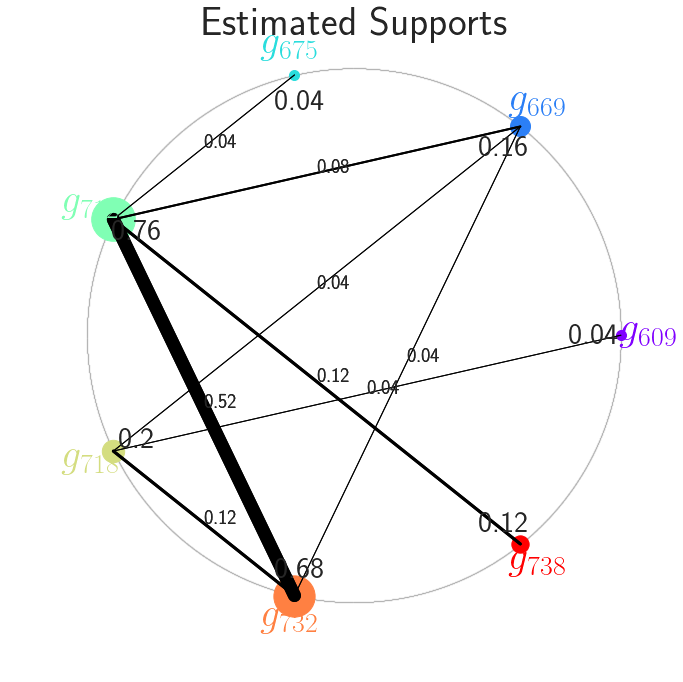

In [8]:
f, axarr = plt.subplots(figsize=(10, 10))
plot_watch3(toplot_l0, names=names_l0, colors=colors_l0, ax = axarr, nreps = 25)
axarr.set_title('Estimated Supports', fontsize=  40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_estimatedsupports')

In [9]:
#colors_l0 = get_color_subset(colors_superset, superset, subset_l0)
subset_l0_plusgt = np.concatenate([[0,8],subset_l0]) #74,176 ground truth
names_l0 = get_names(subset_l0_plusgt)
cuz_l = np.abs(get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_l0_plusgt], 1,2)))
cuz_l0 = np.mean(cuz_l, axis = 0)
colors_l0_plusgt = np.vstack([[[0,0,1,1], [1,.64,0,1]],colors_l0])
detected_values = get_detected_values(subset_l0_plusgt, sel)

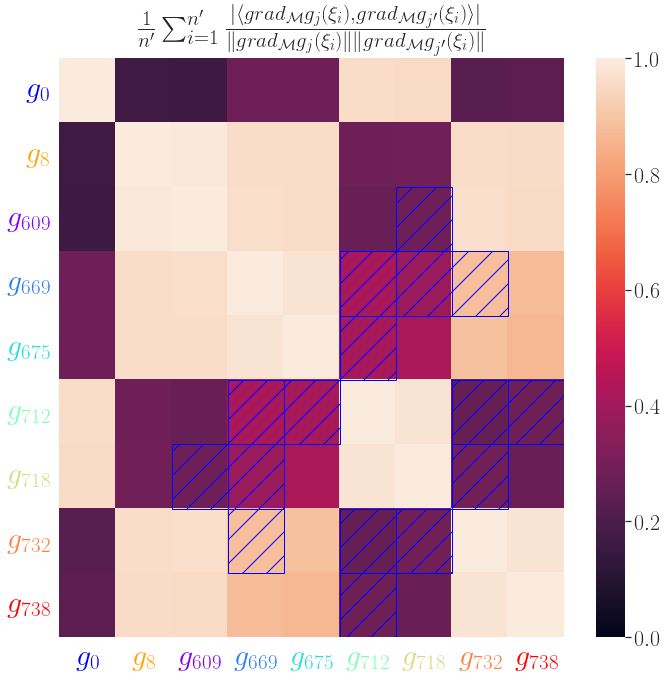

In [10]:
sns.set(font_scale=2)
f, axarr = plt.subplots(figsize=(10, 10))

sns.heatmap(cuz_l0, yticklabels = names_l0, xticklabels = names_l0, ax = axarr, vmin = 0., vmax = 1.)
axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
for d in range(detected_values.shape[1]):
    axarr.add_patch(Rectangle((detected_values[1,d], detected_values[0,d]), 1, 1,facecolor = [0,1,0,0.], hatch = '/',fill= True, edgecolor='blue', lw=1))
for xtick, color in zip(axarr.get_xticklabels(), colors_l0_plusgt):
    xtick.set_color(color)
for ytick, color in zip(axarr.get_yticklabels(), colors_l0_plusgt):
    ytick.set_color(color)
axarr.set_title(r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle|}{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
plt.tight_layout()
plt.yticks(rotation= 0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_estimatedsupport_cosines')

In [11]:
r= 1
subset = sel[r]
colors = np.zeros((756,4))
colors[subset_l0_plusgt] = colors_l0_plusgt
xaxis_reorder = replicates[r].xaxis_reorder
cs_reorder = replicates[r].cs_reorder

In [12]:
mpl.style.use('default')

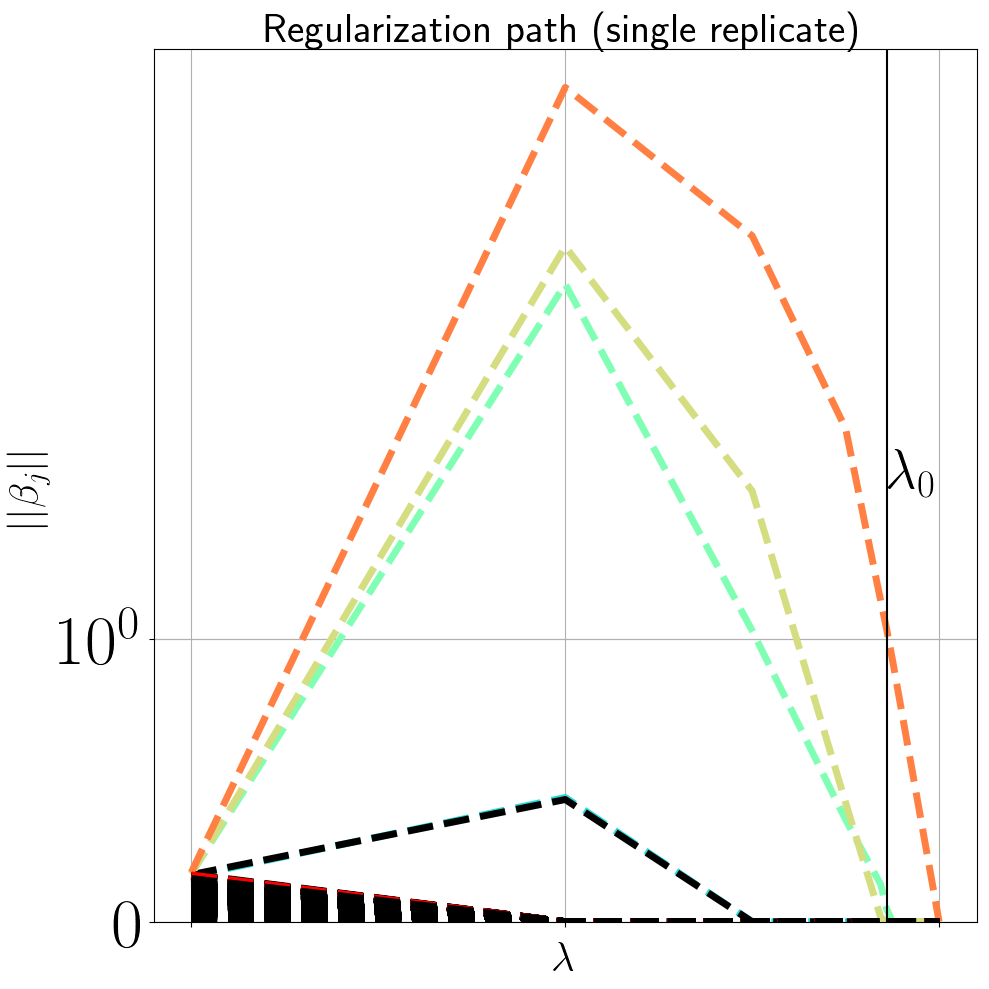

In [14]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
xaxis_norm = xaxis_reorder / xaxis_reorder.max()
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_norm, f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

#axarr.axvline(xaxis_reorder[1] , color = 'black')
#axarr.text(xaxis_reorder[1], 1.5, r'$\lambda_{max} / 2$', fontsize = 40)
axarr.axvline(xaxis_norm[sel_l[r]] , color = 'black')
axarr.text(xaxis_norm[sel_l[r]], 1.5, r'$\lambda_{0}$', fontsize = 40, fontname = 'sans-serif')
axarr.set_title('Regularization path (single replicate)')
axarr.set_xticklabels([])
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_replicate')

#axarr.patch.set_facecolor('None')

In [11]:
natoms = 9
experiment = AtomicRegression(natoms)

#def get_olsnorm_and_supportsbrute(experiment, replicates):
dim = 2
dnoise = 2
#nreps = 5
nsel = 100
#p = 6

supports_brute = {}
for r in range(nreps):
    possebs= min_sel[r]
    p = len(possebs)
    parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
    nparameterizations_possible = parameterizations_possible.shape[0]
    penalties = np.zeros((nreps, nparameterizations_possible))
    #ols_norm = np.zeros((nreps, p, p))
    #subset
    brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
    orthogonality = np.zeros((nsel, nparameterizations_possible))
    for i in range(nsel):
        for j in range(nparameterizations_possible):
            #this swap_axes is CONFUSING........ but works
            brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(replicates[r].dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
            # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
    for j in range(nparameterizations_possible):
        penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
    print('here')
    sbr = parameterizations_possible[penalties[r, :].argmin()]
    supports_brute[r] = possebs[sbr]

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [16]:
subset_brute = np.unique(np.concatenate(list(supports_brute.values())) )
toplot_brute = get_support_indices(subset_brute, supports_brute)
names_brute = get_names(subset_brute)
colors_brute = get_cmap(subset_brute)

1.0 0.0
0.6234898018587336 0.7818314824680297
-0.22252093395631434 0.9749279121818236
-0.900968867902419 0.43388373911755823
-0.9009688679024191 -0.433883739117558
-0.2225209339563146 -0.9749279121818235
0.6234898018587334 -0.7818314824680299


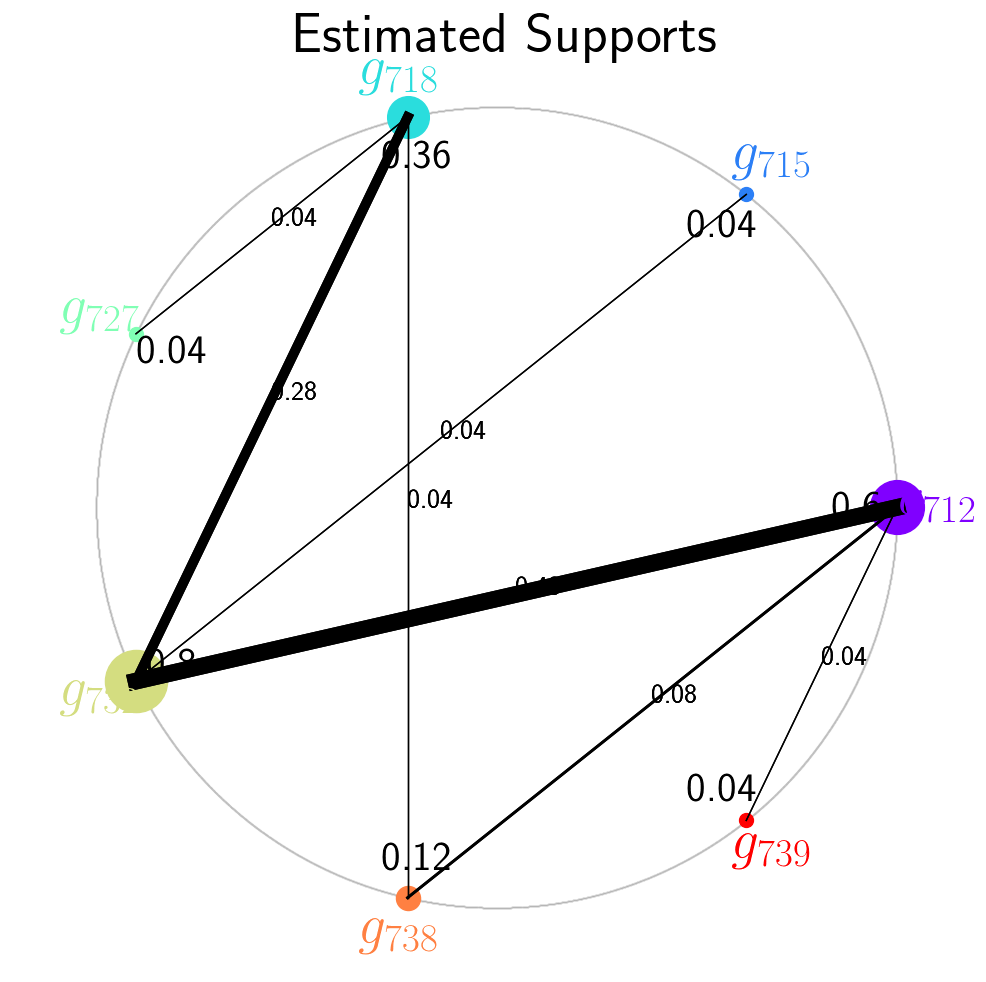

In [17]:
f, axarr = plt.subplots(figsize=(10, 10))
plot_watch3(toplot_brute, names=names_brute, colors=colors_brute, ax = axarr, nreps = nreps)
axarr.set_title('Estimated Supports', fontsize=  40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_prunedict_brutesupport')

In [18]:
#colors_l0 = get_color_subset(colors_superset, superset, subset_l0)
subset_brute_plusgt = np.concatenate([[0,8],subset_brute]) #74,176 ground truth
names_brute = get_names(subset_brute_plusgt)
cuz_l = np.abs(get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_brute_plusgt], 1,2)))
cuz_brute = np.mean(cuz_l, axis = 0)
colors_brute_plusgt = np.vstack([[[0,0,1,1], [1,.64,0,1]],colors_brute])
detected_values = get_detected_values(subset_brute_plusgt, supports_brute)

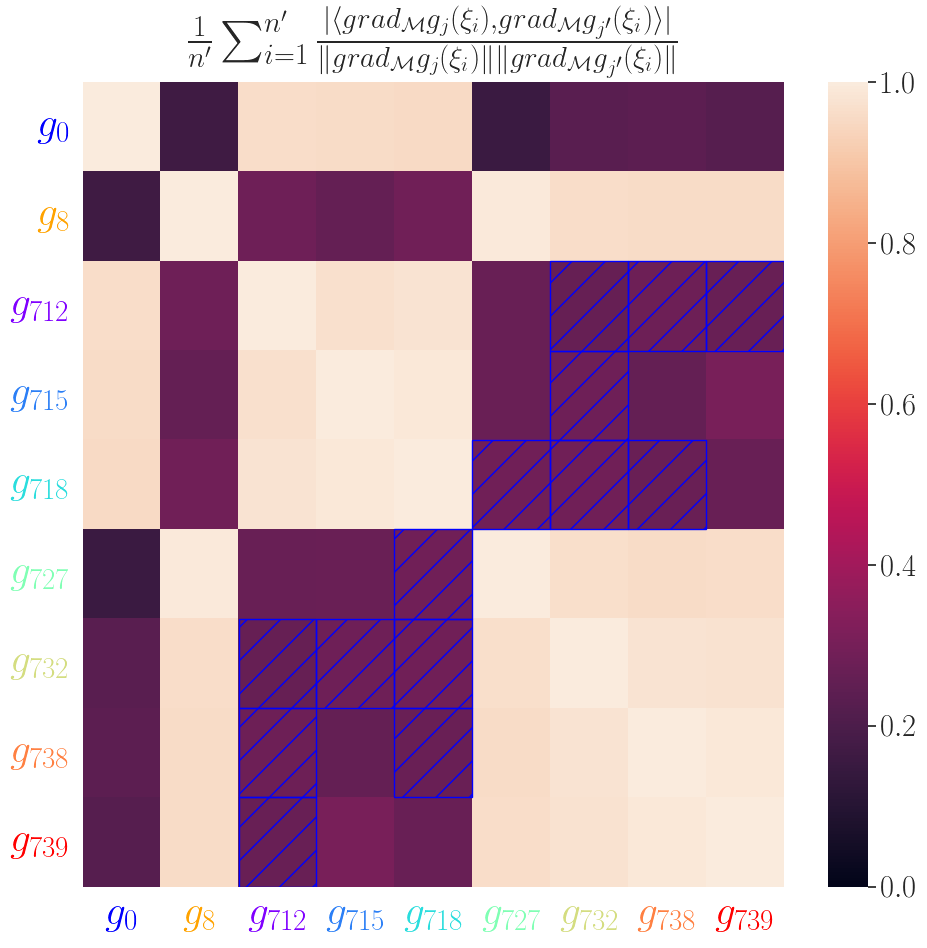

In [19]:
cosines = cuz_brute
names = names_brute
colors = colors_brute_plusgt

sns.set(font_scale=2)
f, axarr = plt.subplots(figsize=(10, 10))

sns.heatmap(cosines, yticklabels = names, xticklabels = names, ax = axarr, vmin = 0., vmax = 1.)
for d in range(detected_values.shape[1]):
    axarr.add_patch(Rectangle((detected_values[1,d], detected_values[0,d]), 1, 1, fill=True, hatch = '/',facecolor = [0,1,0,0.],edgecolor='blue', lw=1))

axarr.set_xticklabels(axarr.get_xmajorticklabels(), fontsize = 30)
axarr.set_yticklabels(axarr.get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr.get_xticklabels(), colors):
    xtick.set_color(color)
for ytick, color in zip(axarr.get_yticklabels(), colors):
    ytick.set_color(color)
axarr.set_title( r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{|\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{j'} (\xi_i)\rangle| }{\|grad_{\mathcal M} g_j (\xi_i) \| \| grad_{\mathcal M} g_{j'}(\xi_i) \|} $" ,
                fontsize = 30)
plt.tight_layout()
plt.yticks(rotation= 0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_prunedict_brutesupport_cosines')

In [20]:
r= 1
#subset = min_sel[r]
subset = supports_brute[r]
#colors_selr = get_color_subset(colors_l0, subset_l0, subset)
colors = np.zeros((756,4))
#colors[:,3] = 1
#colors[r0subset] = colors_r0
colors[subset_brute_plusgt] = colors_brute_plusgt
xaxis_reorder = replicates[r].xaxis_reorder
cs_reorder = replicates[r].cs_reorder

In [28]:
mpl.style.use('default')

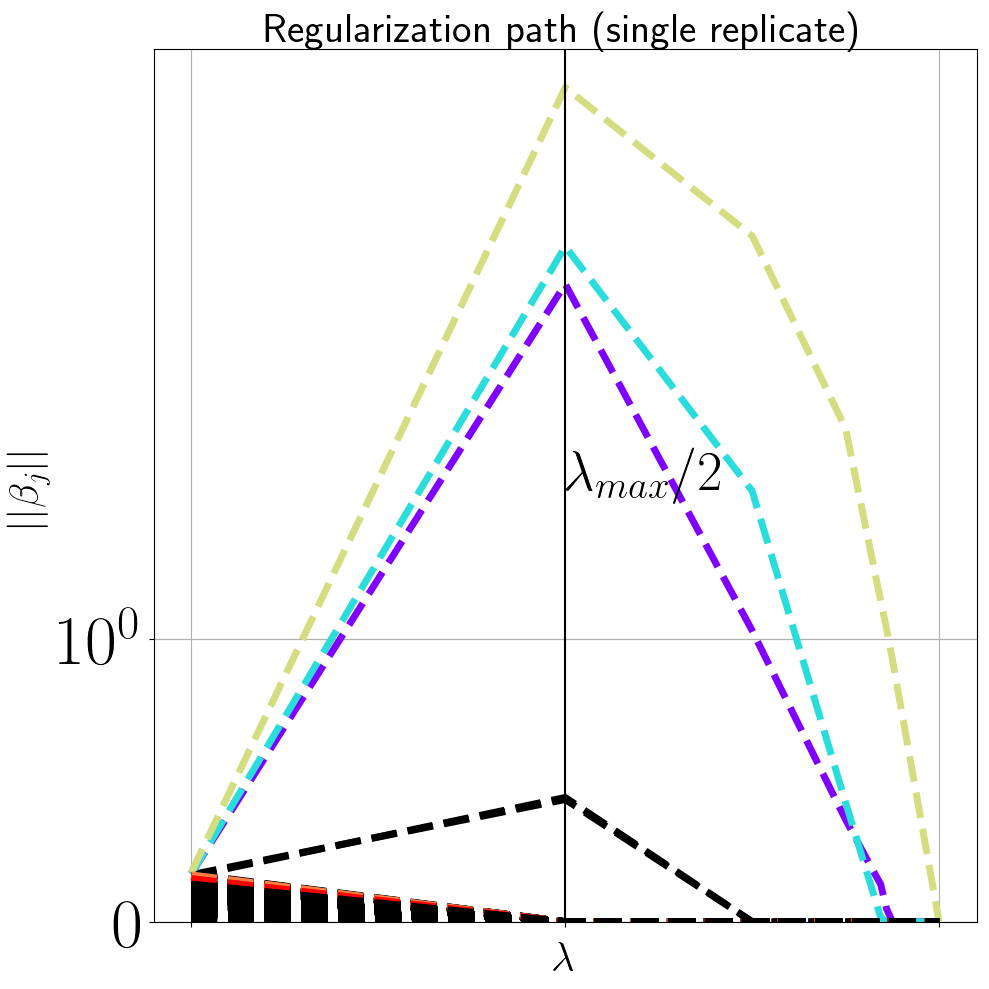

In [33]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
xaxis_norm = xaxis_reorder / xaxis_reorder.max()
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_norm, f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

axarr.axvline(xaxis_norm[1] , color = 'black')
axarr.text(xaxis_norm[1], 1.5, r'$\lambda_{max} / 2$', fontsize = 40, fontname = 'sans-serif')
#axarr.axvline(xaxis_reorder[sel_l[r]] , color = 'black')
#axarr.text(xaxis_reorder[sel_l[r]], 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr.set_title('Regularization path (single replicate)')
axarr.set_xticklabels([])
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_fulldict_replicate_prune')

#axarr.patch.set_facecolor('None')

In [23]:
from datetime import datetime

In [24]:
from codes.otherfunctions.get_dictionaries import get_all_atoms_4, get_atoms_4

In [25]:
ii = np.asarray([0, 0, 0, 1, 1, 1, 2, 2])
jj = np.asarray([4, 5, 1, 6, 7, 2, 3, 8])

In [26]:
atoms4_true, p  = get_atoms_4(9,ii,jj)
atoms_4,p = get_all_atoms_4(9)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel
from codes.otherfunctions.get_grads import get_grads3
from codes.experimentclasses.RigidEthanolPCA3 import get_rigid_ethanol_data

n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 
nreps = 1
natoms = 9

#savename = 'malonaldehyde_021521'
#savefolder = 'malonaldehyde'
#loadfolder = 'malonaldehyde'
#loadname = 'malonaldehyde_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.atoms3, experiment.da = experiment.get_atoms_3()
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)

data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/malonaldehyde.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/malonaldehydeindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/malonaldehydeangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)


/Users/samsonkoelle/manifoldflasso_jmlr


0
1
2
3
4
5


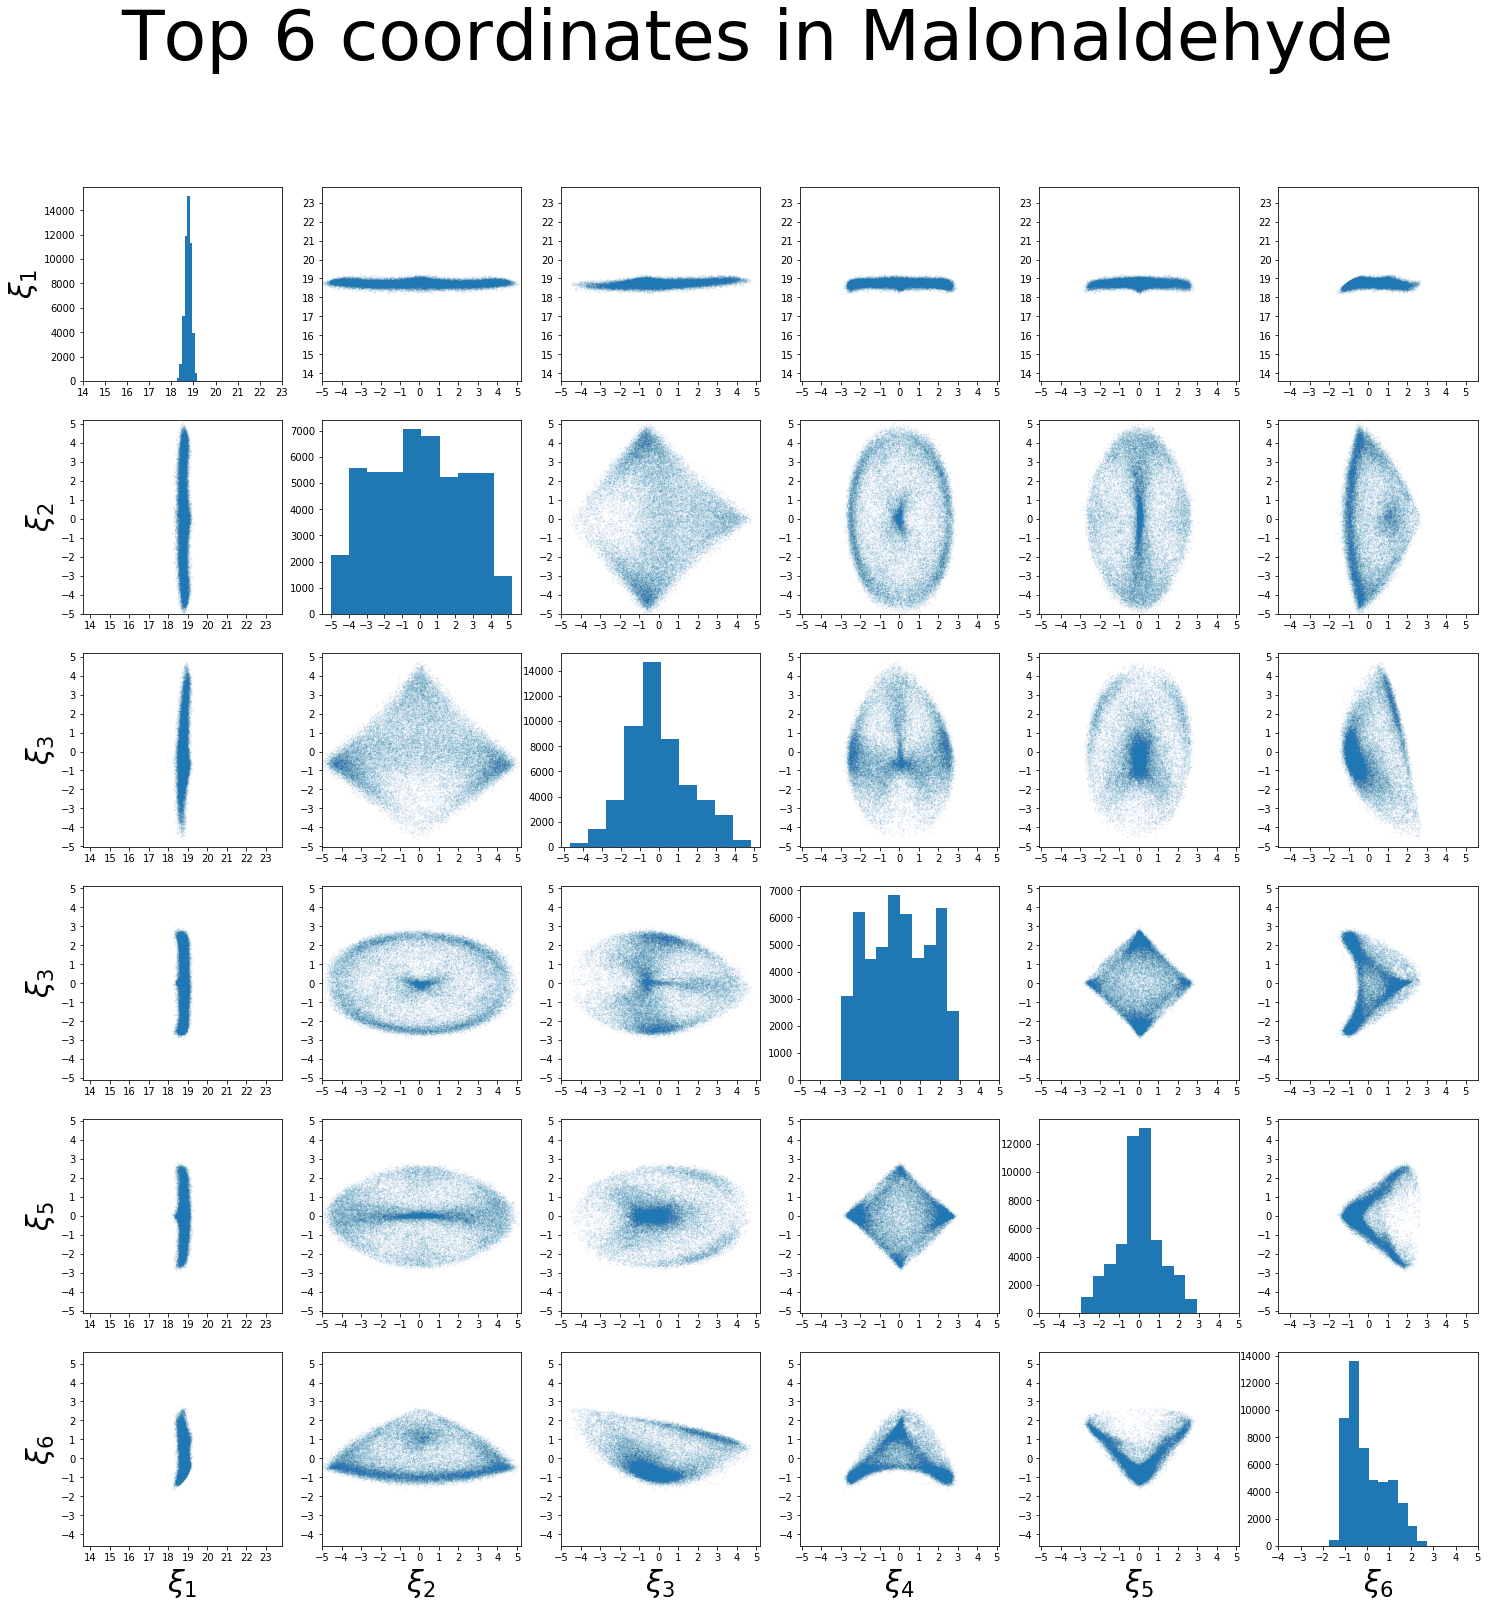

In [9]:
data = experiment.N.data

s = 100
alpha = .5
fig, axes = plt.subplots(6,6, figsize = (25,25))

xmins = np.zeros(6)
xmaxs = np.zeros(6)
xmeans = np.zeros(6)
for d in range(6):
    xmins[d] = experiment.Mpca.data[:,d].min()
    xmaxs[d] = experiment.Mpca.data[:,d].max()    
    xmeans[d] = (xmins[d] +  xmaxs[d]) / 2

gap = (xmaxs - xmins).max()

for d in range(6):
    xmins[d] = xmeans[d] - gap / 2 #experiment.Mpca.data[:,d].min()
    xmaxs[d] = xmeans[d] + gap / 2  #experiment.Mpca.data[:,d].max()    
    #xmeans[d] = (xmins[d] +  xmaxs[d]) / 2
    


for d in range(6):
    print(d)
    for e in range(6):
        xticks = list(range(math.ceil(xmins[d]), math.ceil(xmaxs[d])))
        yticks = list(range(math.ceil(xmins[e]), math.ceil(xmaxs[e])))
        if d != e:
            axes[e,d].scatter(experiment.Mpca.data[:,d],experiment.Mpca.data[:,e], s = .1, alpha = .1)
            axes[e,d].set_xlim(xmins[d], xmaxs[d])
            axes[e,d].set_ylim(xmins[e], xmaxs[e])
            axes[e,d].set_xticks(xticks)
            axes[e,d].set_yticks(yticks)
            #axes[d,e].set_xticklabels([])
            #axes[d,e].set_yticklabels([])
            #axes[d,e].set_xticks([])
            #axes[d,e].set_yticks([])
        if d == e:
            #axes[d,e].set_xticklabels([])
            #axes[d,e].set_yticklabels([])
            #axes[d,e].set_xticks([])
            #axes[d,e].set_yticks([])
            axes[d,e].hist(experiment.Mpca.data[:,d])
            axes[e,d].set_xticks(xticks)


axes[5,0].set_xlabel(r'$\xi_{1}$', fontsize= 30)
axes[5,1].set_xlabel(r'$\xi_{2}$', fontsize= 30)
axes[5,2].set_xlabel(r'$\xi_{3}$', fontsize= 30)
axes[5,3].set_xlabel(r'$\xi_{4}$', fontsize= 30)
axes[5,4].set_xlabel(r'$\xi_{5}$', fontsize= 30)
axes[5,5].set_xlabel(r'$\xi_{6}$', fontsize= 30)

axes[0,0].set_ylabel(r'$\xi_{1}$', fontsize= 30)
axes[1,0].set_ylabel(r'$\xi_{2}$', fontsize= 30)
axes[2,0].set_ylabel(r'$\xi_{3}$', fontsize= 30)
axes[3,0].set_ylabel(r'$\xi_{3}$', fontsize= 30)
axes[4,0].set_ylabel(r'$\xi_{5}$', fontsize= 30)
axes[5,0].set_ylabel(r'$\xi_{6}$', fontsize= 30)

fig = plt.gcf()
fig.suptitle('Top 6 coordinates in Malonaldehyde', fontsize=70)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_xi_pairplot')
#axes[d,e].set_axis_off()#axes.set_   

0
1
2
3
4
5


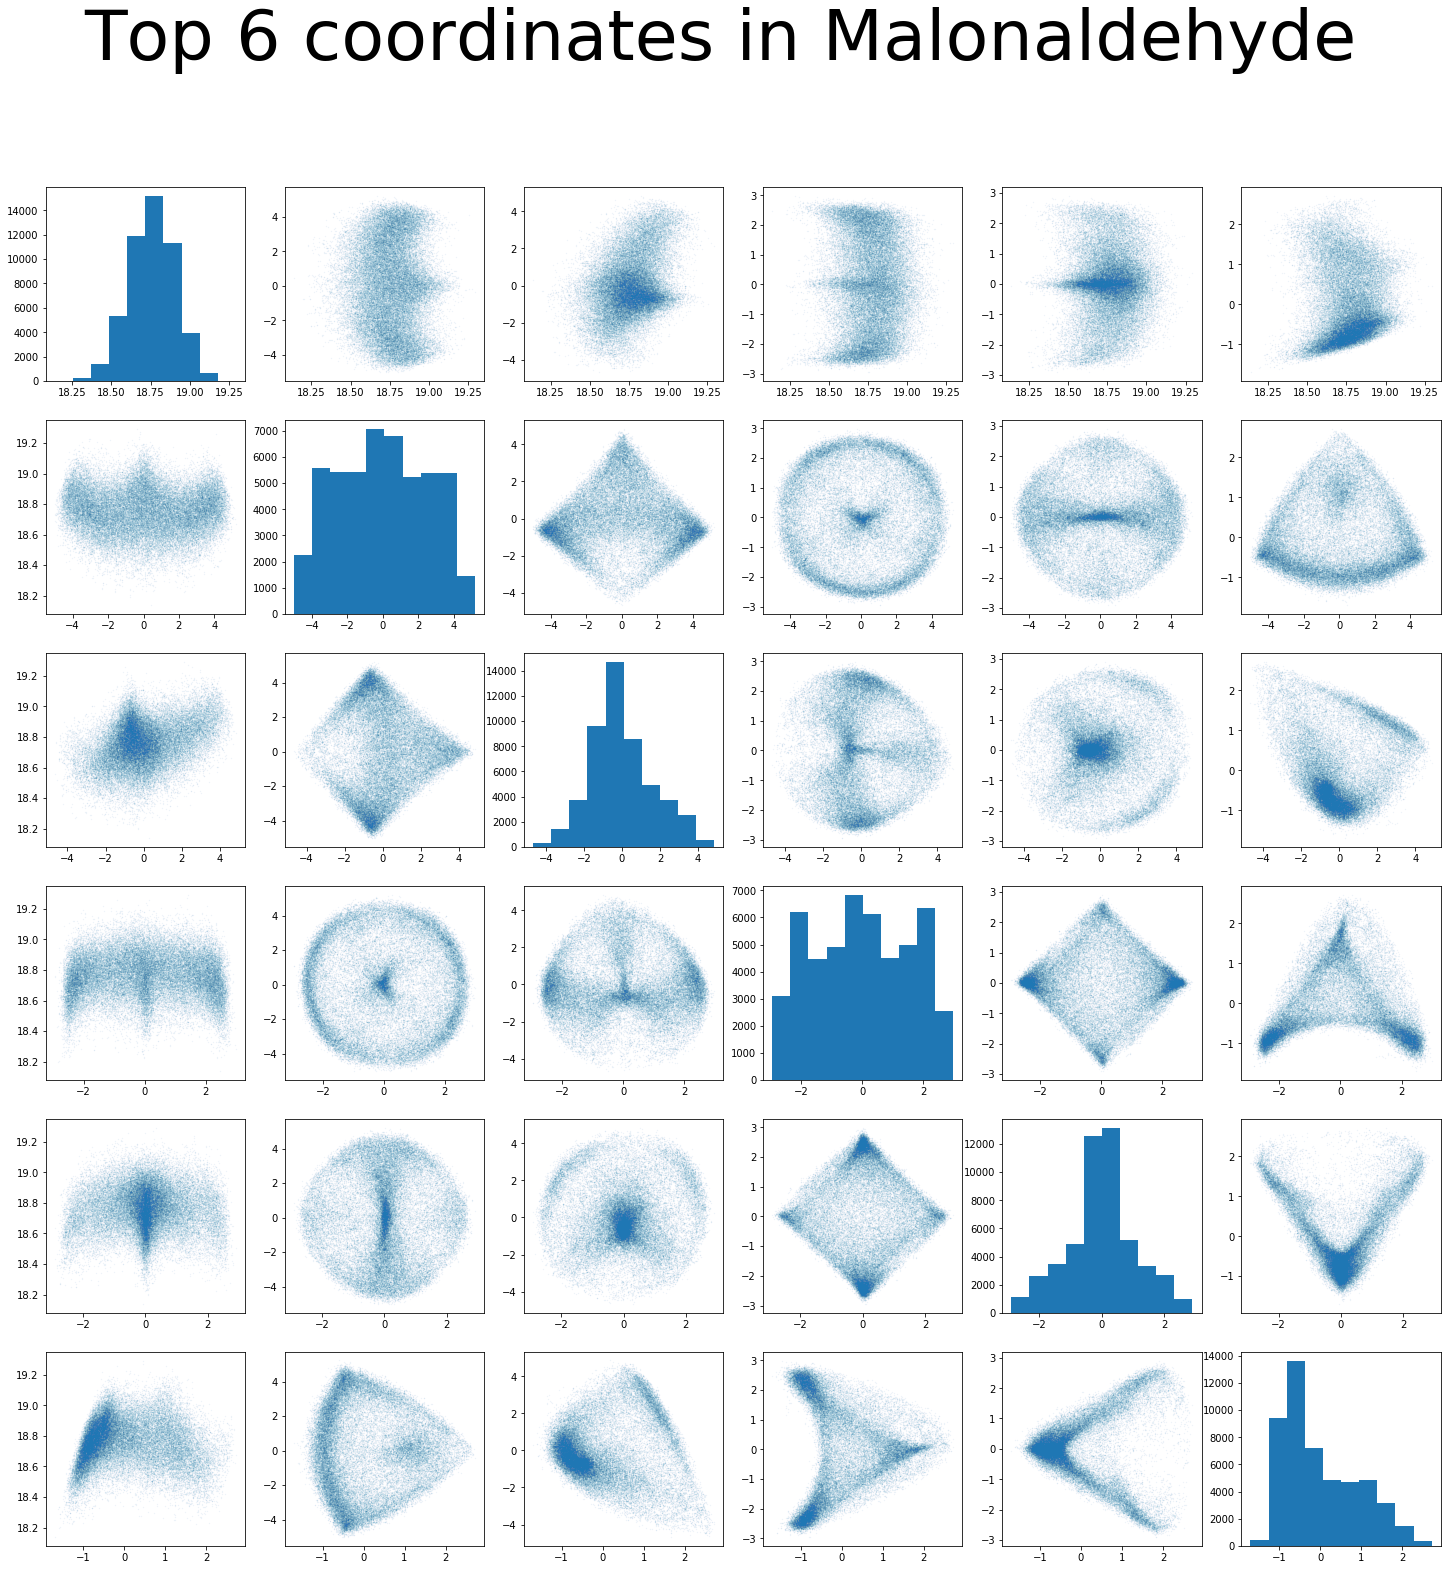

In [2]:
# data = experiment.N.data

# s = 100
# alpha = .5
# fig, axes = plt.subplots(6,6, figsize = (25,25))

# for d in range(6):
#     print(d)
#     for e in range(6):
#         if d != e:
#             axes[d,e].scatter(experiment.Mpca.data[:,d],experiment.Mpca.data[:,e], s = .1, alpha = .1)
#             #axes[d,e].set_xticklabels([])
#             #axes[d,e].set_yticklabels([])
#             #axes[d,e].set_xticks([])
#             #axes[d,e].set_yticks([])
#         if d == e:
#             #axes[d,e].set_xticklabels([])
#             #axes[d,e].set_yticklabels([])
#             #axes[d,e].set_xticks([])
#             #axes[d,e].set_yticks([])
#             axes[d,e].hist(experiment.Mpca.data[:,d])
            
# fig = plt.gcf()
# fig.suptitle('Top 6 coordinates in Malonaldehyde', fontsize=70)

# plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_xi_pairplot')
#             #axes[d,e].set_axis_off()
# #axes.set_   

In [5]:
from codes.otherfunctions.get_dictionaries import get_atoms_4

In [6]:
ii_mal = np.asarray([0, 0, 0, 1, 1, 1, 2, 2])
jj_mal = np.asarray([4, 5, 1, 6, 7, 2, 3, 8])
atoms4_mal, p = get_atoms_4(9,ii_mal,jj_mal)
atoms4_mal[3], atoms4_mal[11]

g1 = experiment.get_g_full_sub(experiment.M.data, atoms4_mal[3])
g2 = experiment.get_g_full_sub(experiment.M.data, atoms4_mal[11])

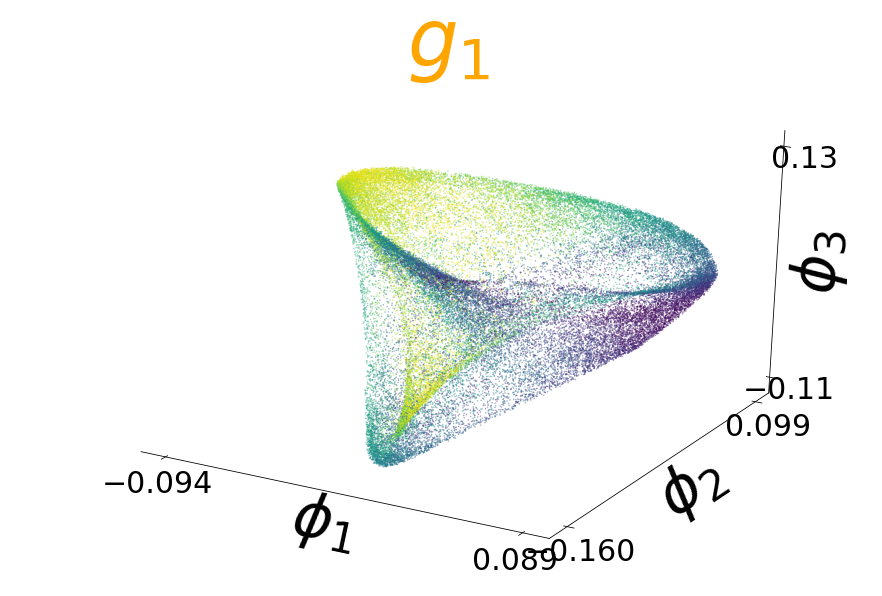

In [10]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)

ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_groundtruth_g1')

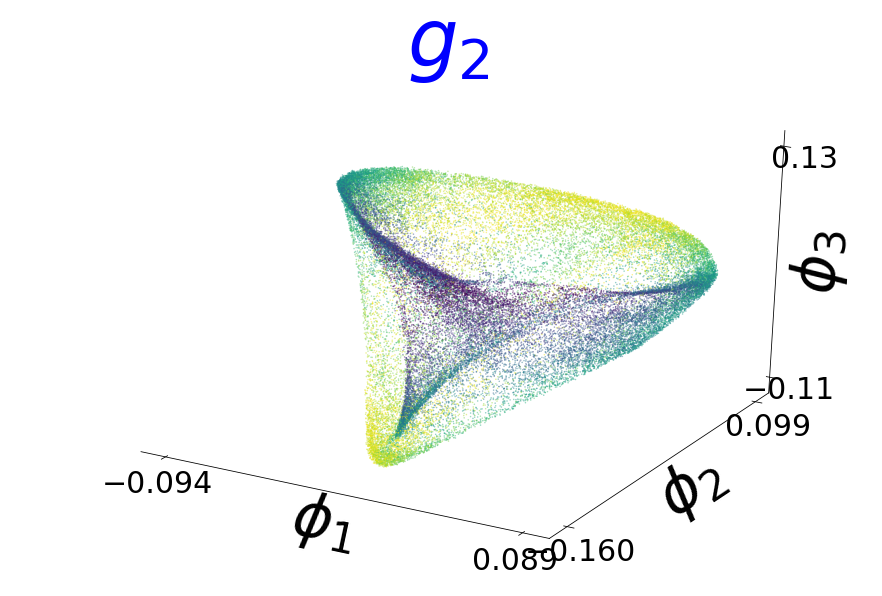

In [9]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(1,1, figsize = (15,10))

axs.set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(x, y, z, c = g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 60)
ax.set_ylabel(r'$\phi_2$', fontsize = 60)
ax.set_zlabel(r'$\phi_3$', fontsize = 60)
ax.set_title(r'$g_{2}$', fontsize = 80, color = 'blue')

xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
ax.set_xticks([xmin, xmax])
ax.set_yticks([ymin, ymax])
ax.set_zticks([zmin, zmax])
ax.tick_params(labelsize=30)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_groundtruth_g2')

0
1
2
3
4
5
6


In [30]:
gb= {}
for b in range(len(subset_brute)):
    print(b)
    gb[b] = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[subset_brute[b]])

# with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0223_fullreplicates_bruteg.pkl' ,
#          'wb') as file:
#      pickle.dump(gb, file)


In [26]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0223_fullreplicates_bruteg.pkl' ,
         'rb') as file:
     gb = pickle.load(file)


0
1
2
3
4
5
6


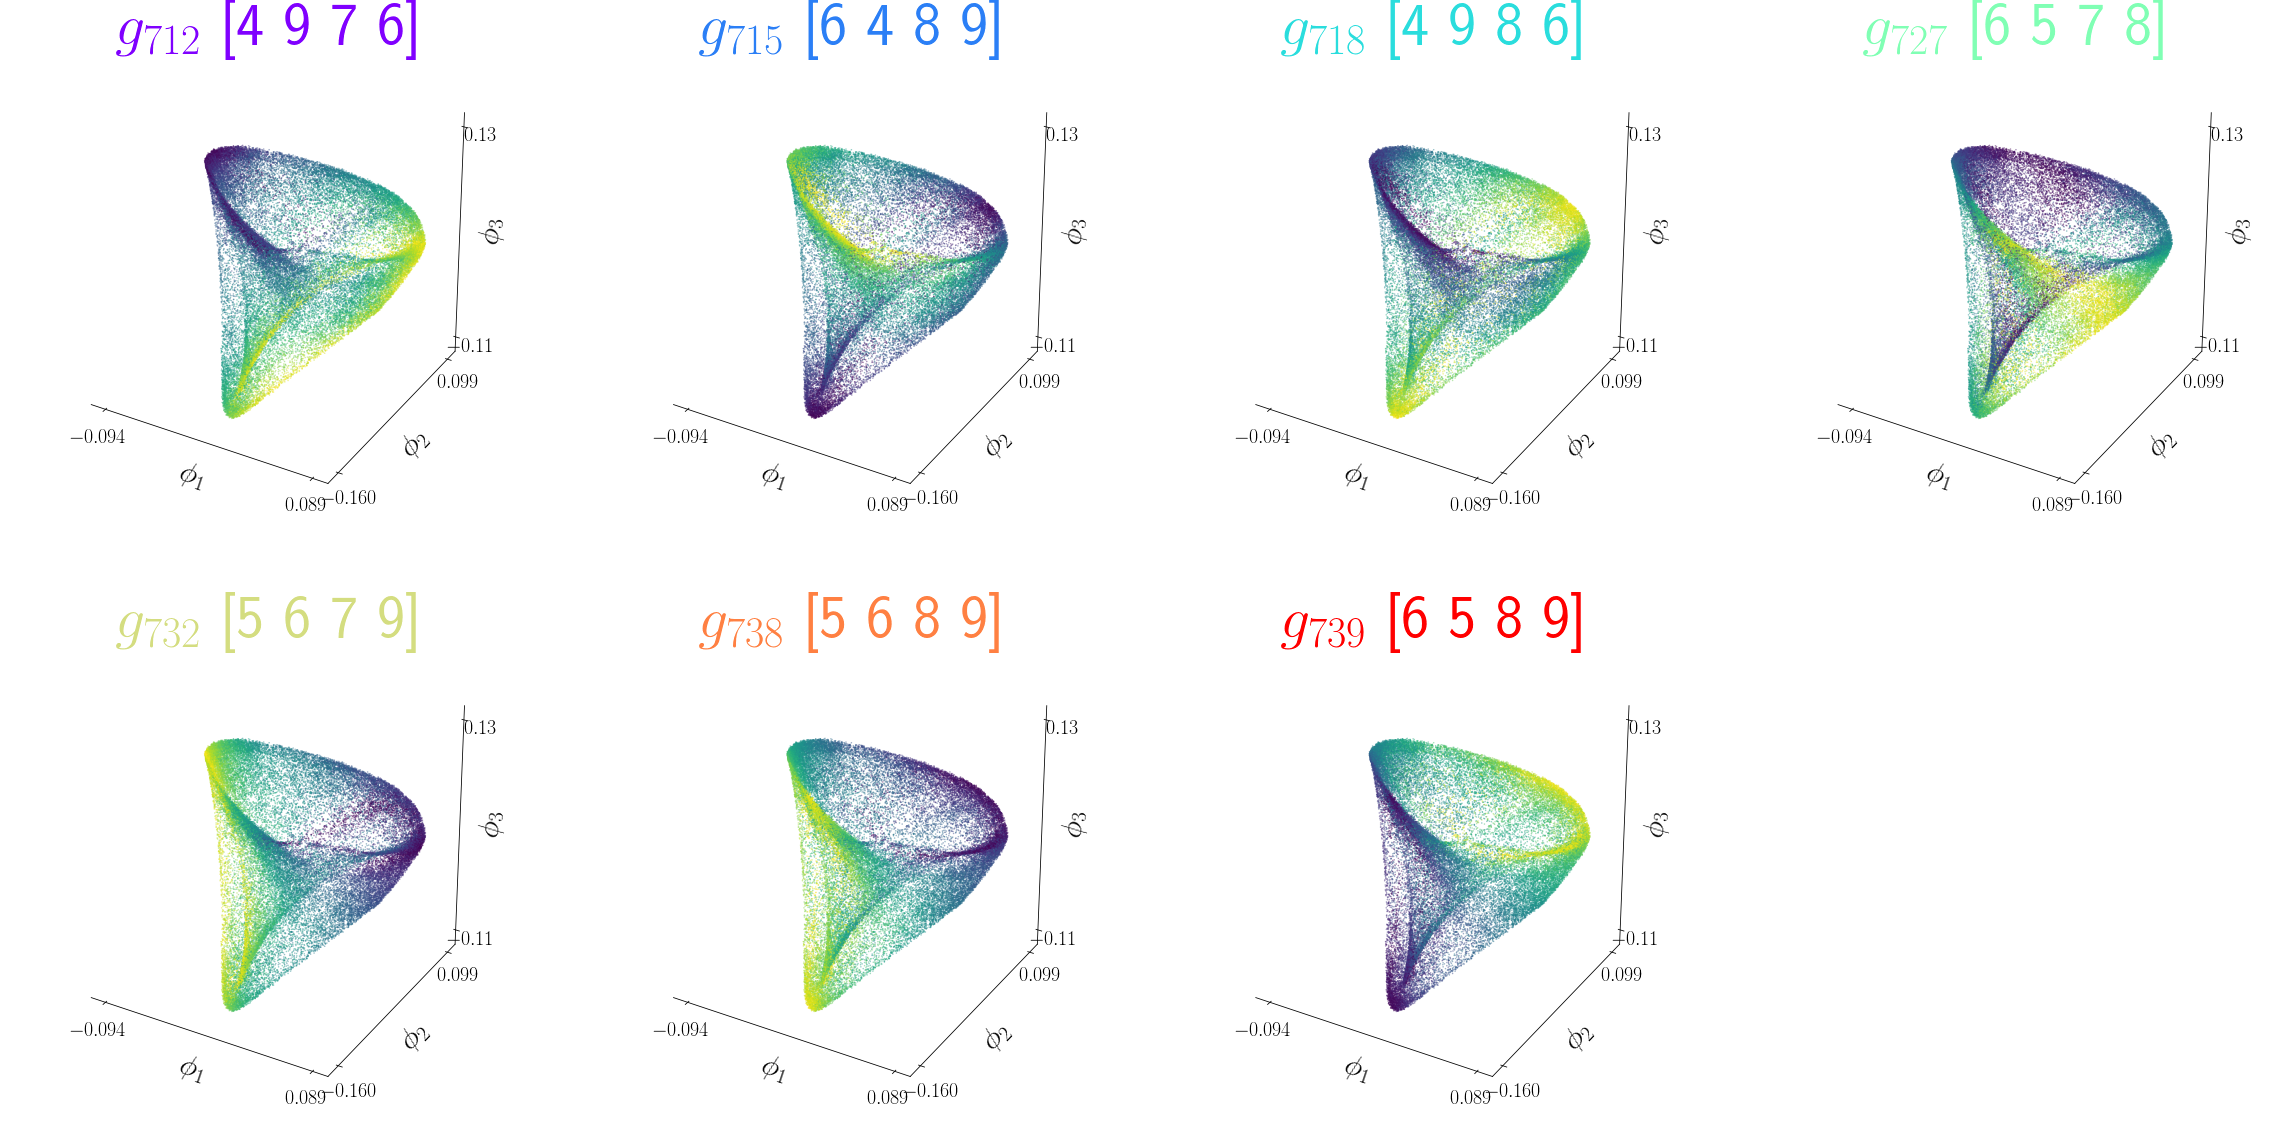

In [48]:
%matplotlib inline
sub = subset_brute
colors = colors_brute
nb = len(sub)
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(math.floor(nb / 4) + 1,4, figsize = (40, 10 *( math.floor(nb / 4) + 1),))

for r in range((math.floor(nb / 4)+1 )* 4):
    axs[math.floor(r / 4), r %4 ].set_axis_off()
    
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(nb):
    print(r)
    ax = fig.add_subplot(math.floor(nb / 4)+1, 4 ,r+1, projection='3d')
    #ax = fig.add_subplot(nb,1, r+1, projection='3d')
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c = gb[r], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize = 30)
    ax.set_ylabel(r'$\phi_2$', fontsize = 30)
    ax.set_zlabel(r'$\phi_3$', fontsize = 30)
    ax.set_title(r'$g_{{{}}}$'.format(sub[r]) + ' ' + str(experiment.atoms4[sub[r]]+1), fontsize = 60, color = colors[r])
    #ax.set_axis_off()
    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
    ax.set_xticks([xmin, xmax])
    ax.set_yticks([ymin, ymax])
    ax.set_zticks([zmin, zmax])
    ax.tick_params(labelsize=20)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_brute_gs')

In [28]:
subset_brute

array([712, 715, 718, 727, 732, 738, 739])

In [29]:
subset_l0

array([609, 669, 675, 712, 718, 732, 738])

In [48]:
gmf= {}
for b in range(len(subset_l0)):
    print(b)
    gmf[b] = experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[subset_l0[b]])
    
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0223_fullreplicates_mfg.pkl' ,
         'wb') as file:
     pickle.dump(gmf, file)


0
1
2
3
4
5
6


In [2]:
with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0223_fullreplicates_mfg.pkl' ,
         'rb') as file:
     gmf = pickle.load(file)


In [43]:
# %matplotlib inline
# nb = len(subset_l0)
# data = experiment.N.data
# axes = [0,1,2]
# s = 100
# alpha = .5

# fig, axs = plt.subplots(math.floor(nb / 4) + 1,4, figsize = (10 *( math.floor(nb / 4) + 1),40))

# for r in range((math.floor(r / 4)+1 )* 4):
#     axs[math.floor(r / 4), r %4 ].set_axis_off()
    
# data = experiment.N.data
# axes = [0,1,2]
# s = 1
# alpha = .5
# selected_points = list(range(50000))
# x = data[:, 0][selected_points]
# y = data[:, 1][selected_points]
# z = data[:, 2][selected_points]
# for r in range(1):
#     print(r)
#     ax = fig.add_subplot(math.floor(nb / 4)+1, 4 ,r+1, projection='3d')
#     ax.scatter(x, y, z, c = gmf[r], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
#     ax.set_xlabel(r'$\phi_1$', fontsize = 30)
#     ax.set_ylabel(r'$\phi_2$', fontsize = 30)
#     ax.set_zlabel(r'$\phi_3$', fontsize = 30)
#     ax.set_title(r'$g_{{{}}}$'.format(subset_l0[r]) + ' ' + str(experiment.atoms4[subset_l0[r]]+1), fontsize = 60, color = colors_l0[r])
#     #ax.set_axis_off()
#     xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
#     xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
#     ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
#     ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
#     zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
#     zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
#     ax.set_xticks([xmin, xmax])
#     ax.set_yticks([ymin, ymax])
#     ax.set_zticks([zmin, zmax])
#     ax.tick_params(labelsize=20)

#     ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     # make the grid lines transparent
#     ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_mf_gs')

0
1
2
3
4
5
6


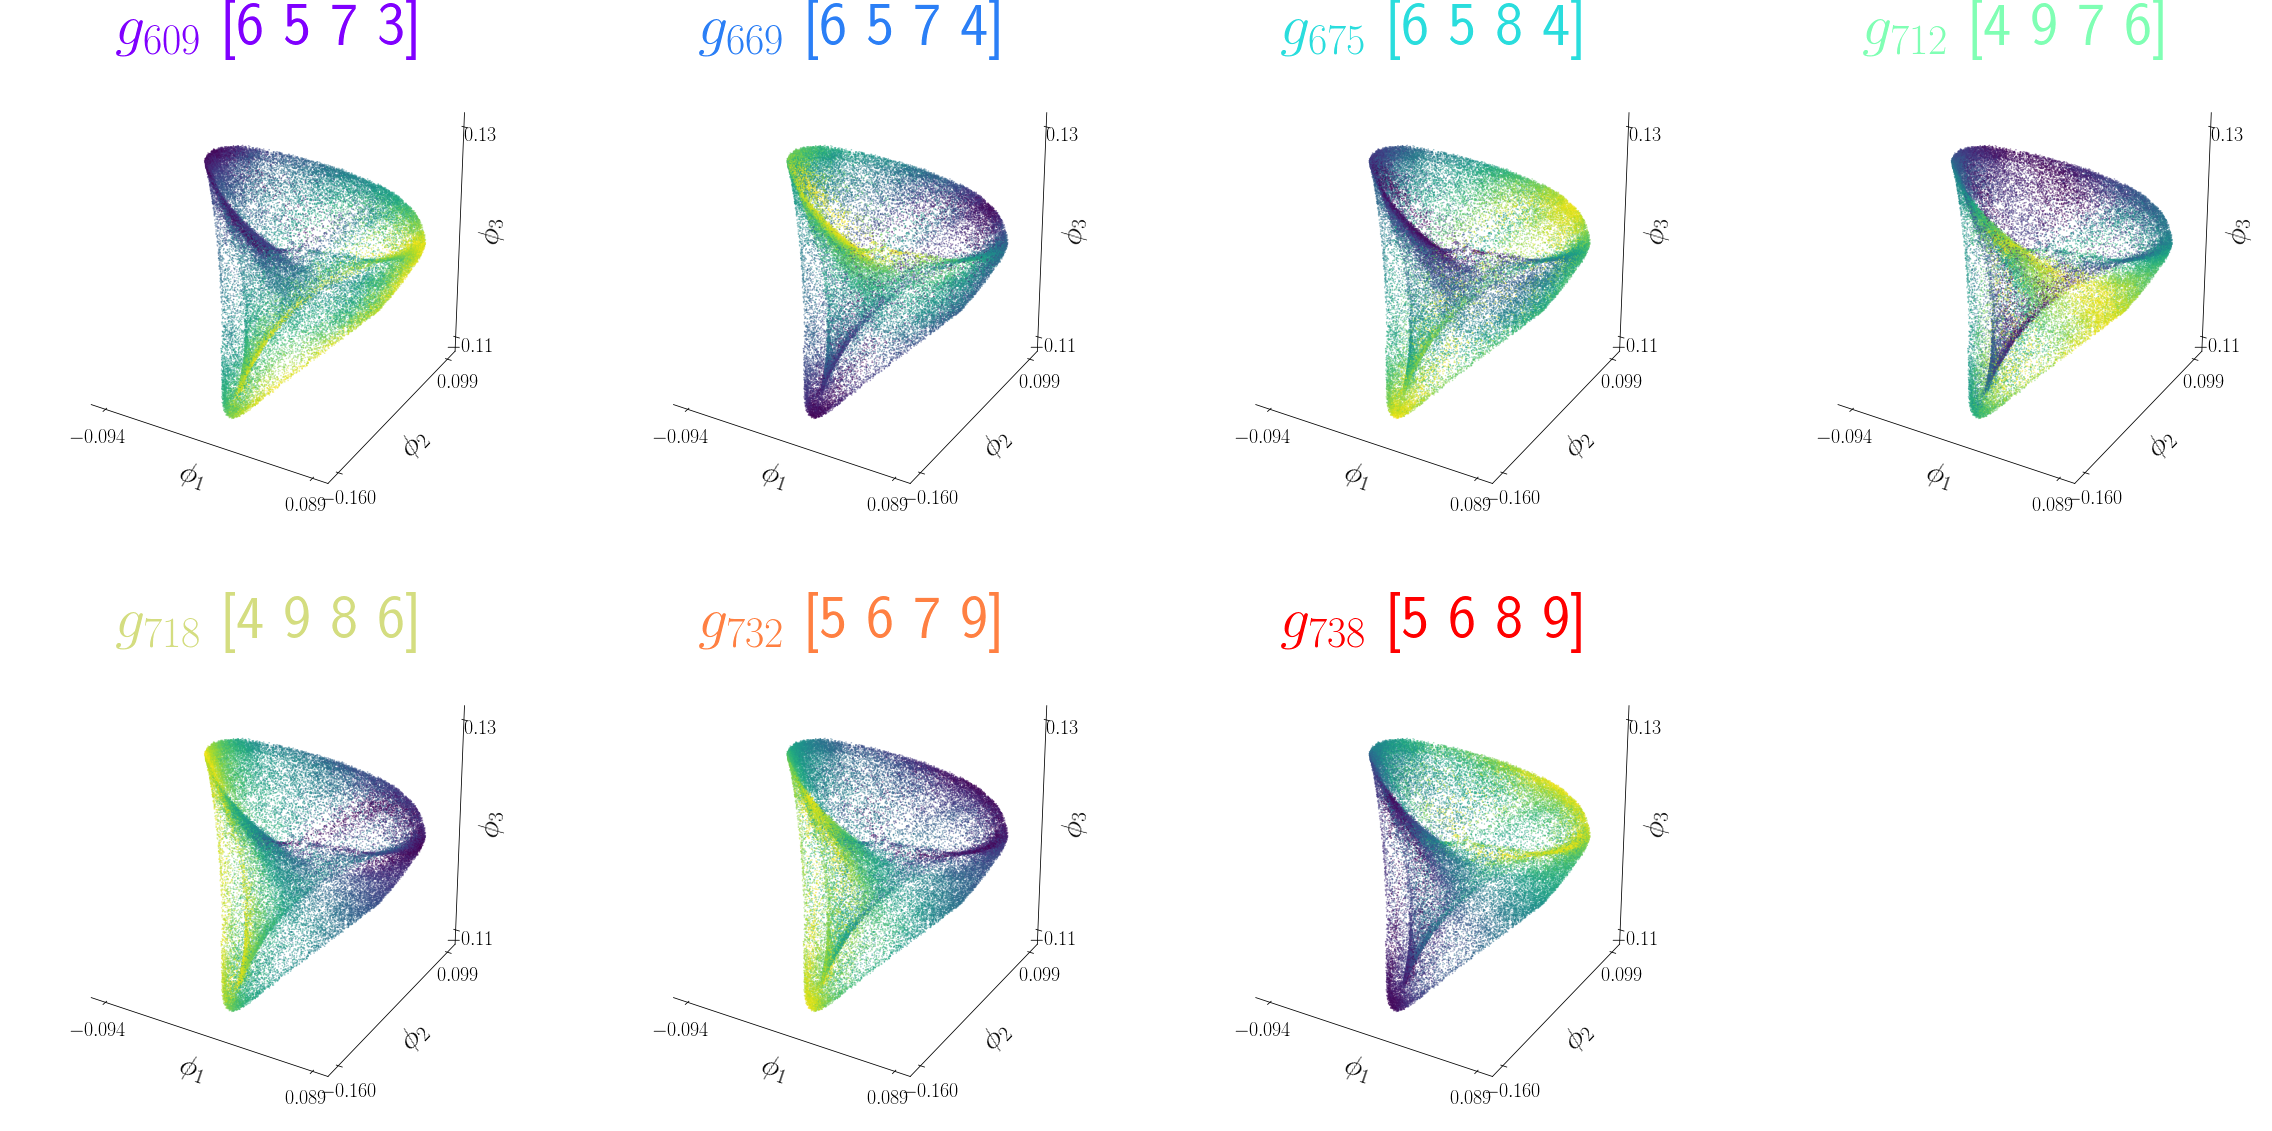

In [45]:
%matplotlib inline
sub = subset_l0
colors = colors_l0
nb = len(sub)
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(math.floor(nb / 4) + 1,4, figsize = (40, 10 *( math.floor(nb / 4) + 1),))

for r in range((math.floor(nb / 4)+1 )* 4):
    axs[math.floor(r / 4), r %4 ].set_axis_off()
    
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(nb):
    print(r)
    ax = fig.add_subplot(math.floor(nb / 4)+1, 4 ,r+1, projection='3d')
    #ax = fig.add_subplot(nb,1, r+1, projection='3d')
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c = gb[r], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize = 30)
    ax.set_ylabel(r'$\phi_2$', fontsize = 30)
    ax.set_zlabel(r'$\phi_3$', fontsize = 30)
    ax.set_title(r'$g_{{{}}}$'.format(sub[r]) + ' ' + str(experiment.atoms4[sub[r]]+1), fontsize = 60, color = colors[r])
    #ax.set_axis_off()
    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
    ax.set_xticks([xmin, xmax])
    ax.set_yticks([ymin, ymax])
    ax.set_zticks([zmin, zmax])
    ax.tick_params(labelsize=20)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_mf_gs')